In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'

# 1. 루빅스 테슬라 전환 뉴스탭 10-1

In [171]:
df1_pre = pd.read_csv("./data/1_1.csv", dtype={"user_tuid_hash": str, "user_tsid_hash": str, "체류시간(초)":np.float64, "클릭수":np.float64}, na_values=["체류시간(초)", "클릭수"])
df1_post = pd.read_csv("./data/1_2.csv", dtype={"user_tuid_hash": str, "user_tsid_hash": str, "체류시간(초)":np.float64, "클릭수":np.float64}, na_values=["체류시간(초)", "클릭수"])

In [181]:
# 오류 제거 (체류시간, 클릭수에 값이 문자형으로 잡힌 엔트리가 있음)
df1_pre = df1_pre.dropna().reset_index(drop=True)
df1_post = df1_post.dropna().reset_index(drop=True)

In [96]:
df1_pre = pd.read_csv("./data/1_1.csv")
df1_post = pd.read_csv("./data/1_2.csv")

# 유저 id 자료형 전처리 (현재 두 데이터프레임에서의 자료형이 서로 다름)
df1_pre.user_tuid_hash = df1_pre.user_tuid_hash.astype(int).astype(str)

print(df1_pre.shape)
print(df1_post.shape)

/Users/kakao/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(11886832, 9)
(19367435, 9)


In [97]:
# 데이터 병합
df_total = df1_pre.append(df1_post)
df_total = df_total[df_total.variation != "variation"].reset_index(drop=True) # 오류 제거

## Variation 할당 비율 + SRM 체크

In [4]:
var_ratio = np.round(df_total.variation.value_counts() / df_total.variation.value_counts().sum(), 5)

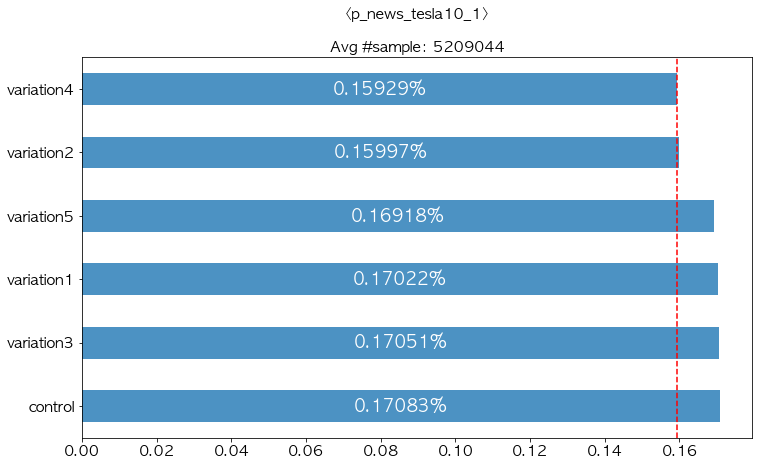

In [5]:
plt.figure(figsize=(12,7))
var_ratio.plot(kind="barh", alpha=0.8)
for i in range(len(var_ratio)):
    temp = var_ratio[i]
    plt.text(temp/2, i, "{}%".format(temp), va = 'center', ha = 'center', fontsize=("xx-large"), color="white")
plt.axvline(x=var_ratio.min(), color="red", linestyle="--")
plt.title("<{}>\n\nAvg #sample: {:.0f}".format(df_total.experiment.unique()[0], df_total.variation.value_counts().mean()), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [6]:
from scipy.stats import chisquare

chi = chisquare(df_total.variation.value_counts())
if chi[1] < 0.05:
    print("##################################################\nWarning: SRM exists.\np-value: {}\n##################################################".format(chi[1]))
else:
    print("No SRM")

##################################################
p-value: 0.0
##################################################


## OS별 할당 비율

In [7]:
for var in df_total.variation.unique():
    temp = df_total[df_total.variation == var].os.value_counts().head() / df_total[df_total.variation == var].os.value_counts().head().sum()
    temp = pd.DataFrame(temp).T
    temp.rename(index={"os": var}, inplace=True)
    if var == "control":
        total = temp.copy()
    else:
        total = total.append(temp)

In [8]:
total

,['android'],['ios'],['macintosh'],['windows'],['linux']
control,0.830441,0.168498,0.000714,0.000186,0.000162
variation1,0.827324,0.171470,0.000729,0.000196,0.000280
variation2,0.829229,0.169442,0.000762,0.000221,0.000346
variation3,0.828708,0.170019,0.000810,0.000210,0.000254
variation4,0.829493,0.169302,0.000781,0.000176,0.000248
variation5,0.827056,0.171737,0.000779,0.000193,0.000234


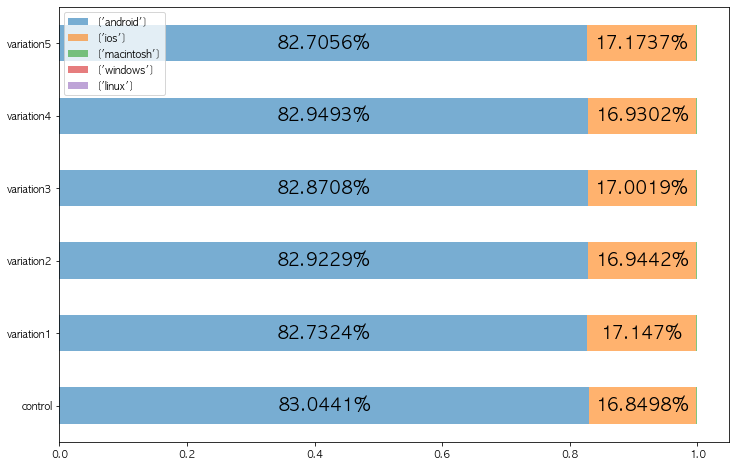

In [9]:
total.plot(kind="barh", stacked=True, figsize=(12,8), alpha=0.6, mark_right=True)
for i in range(len(total.index)):
    temp = total.iloc[i, :]
    total_cumsum = temp.cumsum()
    plt.text(total_cumsum[0]/2, i, str(np.round(total_cumsum[0]*100, 4)) + '%', va = 'center', ha = 'center', fontsize=("xx-large"))
    plt.text(total_cumsum[0] + (total_cumsum[1] - total_cumsum[0])/2, i, 
        str(np.round((total_cumsum[1]-total_cumsum[0])*100, 4)) + '%', va = 'center', ha = 'center', fontsize=("xx-large"))
plt.show()

In [10]:
# OS별 SRM 체크
for col in total.columns:
    ratio_temp = total[col] * df_total[df_total.os == col].groupby("variation")["os"].count()
    chi = chisquare(ratio_temp)
    if chi[1] < 0.05:
        print("##################################################")
        print("<{}>\nWarning: SRM exists.\np-value: {}".format(col, chi[1]))
    else:
        print("##################################################")
        print("<{}>\nNo SRM".format(col))
    print()

##################################################
<['android']>
p-value: 0.0

##################################################
<['ios']>
p-value: 6.600825275140961e-267

##################################################
<['macintosh']>
No SRM

##################################################
<['windows']>
No SRM

##################################################
<['linux']>
No SRM



## 아웃라이어 처리

- 99% quantile capping

In [11]:
def capping(data, zero_inflated=False, verbose=False):
    temp = data.copy()
    if zero_inflated:
        # 0이 아닌 부분에서 99% 분위수로 capping
        nonzeros = temp[temp != 0]
        zeros = temp[temp == 0]
        if verbose:
            print("Proportion of zeros: {}%".format(np.round(len(zeros) / len(temp) * 100, 3)))
        quantile_idx = int(np.round(len(nonzeros) * 0.99))
        quantile_val = np.sort(nonzeros)[quantile_idx]
        idx_to_replace = nonzeros[nonzeros > quantile_val].index
    else:
        # 0을 포함한 전체에서 99% 분위수로 capping
        quantile_idx = int(np.round(len(temp) * 0.99))
        quantile_val = np.sort(temp)[quantile_idx]
        idx_to_replace = temp[temp > quantile_val].index

    temp[idx_to_replace] = quantile_val
    return temp

## Delta Method

- randomization unit: 유저
- analysis unit이 randomization unit과 다른 (ex. "세션당" 클릭수/체류시간) 지표에 대해서 델타 메소드로 분산을 보정

In [12]:
df_total

,experiment,variation,user_tuid_hash,user_tsid_hash,체류시간(초),클릭수,est_age,est_gender,os
0,p_news_tesla10_1,control,669966342553.0,684691212930471912,116,2,[],[],['ios']
1,p_news_tesla10_1,control,669966342553.0,1084543055795338830,110,1,[],[],['ios']
2,p_news_tesla10_1,control,669966342553.0,1398812206124552717,201,4,[],[],['ios']
3,p_news_tesla10_1,control,669966342553.0,1991034777342499683,77,1,[],[],['ios']
4,p_news_tesla10_1,control,669966342553.0,1997182607878879776,138,2,[],[],['ios']
...,...,...,...,...,...,...,...,...,...
31254257,p_news_tesla10_1,variation5,18446487600670444056,7896498323161242426,0,0,['51'],['M'],['android']
31254258,p_news_tesla10_1,variation5,18446487600670444056,10474832693036067366,0,0,['51'],['M'],['android']
31254259,p_news_tesla10_1,variation5,18446487600670444056,13962624005763172624,0,0,['51'],['M'],['android']
31254260,p_news_tesla10_1,variation5,18446487600670444056,18009107852722872098,0,0,['51'],['M'],['android']


In [13]:
session_nums = df_total.user_tsid_hash.value_counts()
print((session_nums > 1).sum())
print((session_nums == 1).sum())

10202
31233857


- 세션 아이디가 두개 이상인 경우가 있음

In [14]:
# 세션 배정 오류 확인
error = df_total[df_total.user_tsid_hash.isin(session_nums[session_nums != 1].index)].groupby("user_tsid_hash").variation.unique()
error[error.apply(lambda x: len(x)) > 1]

user_tsid_hash
356710306142664099         [control, variation3]
682737976098964104      [variation1, variation5]
777858618606193275         [control, variation4]
1162425669627650579     [variation1, variation2]
1362207287107494562        [control, variation1]
                                  ...           
18262467541494876543    [variation1, variation3]
18326614408436690061       [control, variation4]
18428039244025906797    [variation1, variation2]
15558226214328213235    [variation1, variation3]
7974990121348817234     [variation4, variation5]
Name: variation, Length: 99, dtype: object

- 동일한 해시 ID를 갖는 세션이 서로 다른 variation에 할당되어 있음

In [15]:
# 단순히 데이터를 두개로 쪼갠 것 (pre-experiment) 으로부터 발생되는 오류가 아님 --> 추가적인 조사가 필요함
error_pre = df1_pre[df1_pre.user_tsid_hash.isin(session_nums[session_nums != 1].index)].groupby("user_tsid_hash").variation.unique()
error_ex = df1_post[df1_post.user_tsid_hash.isin(session_nums[session_nums != 1].index)].groupby("user_tsid_hash").variation.unique()

print(len(error_pre[error_pre.apply(lambda x: len(x)) > 1]))
print(len(error_ex[error_ex.apply(lambda x: len(x)) > 1]))

error_pre[error_pre.apply(lambda x: len(x)) > 1].head()

33
66


user_tsid_hash
356710306142664099        [control, variation3]
682737976098964104     [variation1, variation5]
777858618606193275        [control, variation4]
1593170687528550619    [variation1, variation4]
1846914305254838012       [control, variation2]
Name: variation, dtype: object

- 일단 해당 데이터들은 제외하고 분석을 진행. 
- 추후 실험 유저 할당과 관련해서 깊이 있는 진단이 필요할 것으로 생각됨.

In [16]:
error_idx = session_nums[session_nums > 1].index
df_delta = df_total[~df_total.user_tsid_hash.isin(session_nums)] # 델타 메소드 검증에 사용할 데이터
df_delta["체류시간(초)"] = df_delta["체류시간(초)"].astype(int)
df_delta["클릭수"] = df_delta["클릭수"].astype(int)

### 적용

In [17]:
from scipy.stats import norm

def standard_test(data, grp1_name, grp2_name, metric_name, apply_capping=True, verbose=True, zero_inflated=True):
    """
    분산 보정을 하지 않는 경우 세션 레벨 지표에 대한 이표본 검정
    """
    # 특정한 두 그룹에서의 관심 지표
    grp1 = data[data.variation == grp1_name][metric_name]
    grp2 = data[data.variation == grp2_name][metric_name]
    if apply_capping:
        grp1 = capping(grp1, zero_inflated=zero_inflated)
        grp2 = capping(grp2, zero_inflated=zero_inflated)
    
    # 검정 통계량 및 p-value 계산
    n1 = len(grp1)
    n2 = len(grp2)
    var1 = grp1.var()
    var2 = grp2.var()

    diff = grp1.mean() - grp2.mean()
    std_error = np.sqrt(var1/n1 + var2/n2)

    zstat = diff / std_error
    pvalue = norm.sf(abs(zstat))*2  # 양측 검정

    # 결과 출력
    if verbose:
        print("검정통계량 (Z-score): {}".format(np.round(zstat, 4)))
        print("p-value: {}".format(np.round(pvalue, 5))) 

    return zstat, pvalue


def apply_delta_method(data, grp1_name, grp2_name, metric_name, apply_capping=True, verbose=True, zero_inflated=True):
    """
    델타 메소드를 이용해서 분산 보정을 하는 경우 세션 레벨 지표에 대한 이표본 검정
    """
    # 특정한 두 그룹에서의 관심 지표
    grp1 = data[data.variation == grp1_name][metric_name]
    grp2 = data[data.variation == grp2_name][metric_name]

    if apply_capping:
        grp1 = capping(grp1, zero_inflated=zero_inflated)
        grp2 = capping(grp2, zero_inflated=zero_inflated)

    def get_variance(grp_name):
        temp = data[data.variation == grp_name]
        if apply_capping:
            temp = temp[temp[metric_name] <= capping(temp[metric_name], zero_inflated=zero_inflated).max()]
        
        Ki = temp.groupby("user_tuid_hash")[metric_name].count()  # 유저별 총 세션 수
        Yi = temp.groupby("user_tuid_hash")[metric_name].sum()    # 유저별 세션 지표의 합

        comp1 = (1/np.mean(Ki)**2) * np.var(Yi)
        comp2 = (np.mean(Yi)**2 / np.mean(Ki)**4) * np.var(Ki)
        comp3 = (np.mean(Yi) / np.mean(Ki)**3) * np.cov(Yi, Ki)[0,1]
        n = len(temp.user_tuid_hash.unique())
        adj_variance = (comp1 + comp2 - 2*comp3) / n

        return adj_variance
    
    # 보정된 분산 계산
    var1 = get_variance(grp1_name)
    var2 = get_variance(grp2_name)

    # 검정통계량 및 p-value 계산
    diff = grp1.mean() - grp2.mean()
    std_error = np.sqrt(var1 + var2)
    zstat = diff / std_error
    pvalue = norm.sf(abs(zstat))*2  # 양측 검정

    # 결과 출력
    if verbose:
        print("검정통계량 (Z-score): {}".format(np.round(zstat, 4)))
        print("p-value: {}".format(np.round(pvalue, 5)))

    return zstat, pvalue

#### 세션당 체류시간

In [18]:
from itertools import combinations
from tqdm import tqdm_notebook

grp_names = df_delta.variation.unique()

stat_naive = []
stat_delta = []
pvalue_naive = []
pvalue_delta = []

for combs in tqdm_notebook(list(combinations(grp_names, 2))):
    temp_naive = standard_test(df_delta, combs[0], combs[1], "체류시간(초)", apply_capping=True, verbose=False)
    temp_delta = apply_delta_method(df_delta, combs[0], combs[1], "체류시간(초)", apply_capping=True, verbose=False)
    
    stat_naive.append(temp_naive[0])
    stat_delta.append(temp_delta[0])

    pvalue_naive.append(temp_naive[1])
    pvalue_delta.append(temp_delta[1])

/var/folders/h1/swk1rnv174d41hkn7g_hlyb00000gn/T/ipykernel_10783/486202908.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for combs in tqdm_notebook(list(combinations(grp_names, 2))):


  0%|          | 0/15 [00:00<?, ?it/s]

/var/folders/h1/swk1rnv174d41hkn7g_hlyb00000gn/T/ipykernel_10783/768069826.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


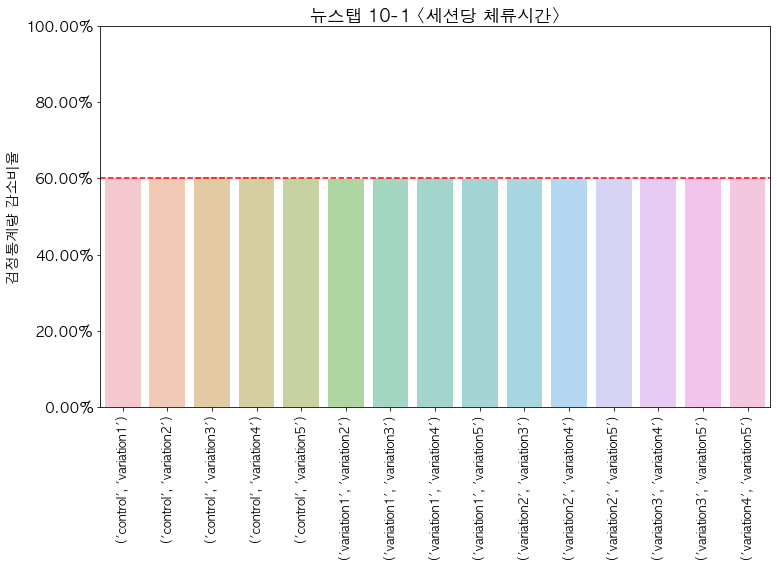

In [19]:
# 검정 통계량 감소율 확인

data_viz = pd.DataFrame({"x": list(combinations(grp_names, 2)), "y": (1 - np.divide(stat_delta, stat_naive))})

plt.figure(figsize=(12,7))
ax = sns.barplot(x="x", y="y", data=data_viz, alpha=0.5)
plt.axhline(data_viz.y.mean(), color="red", linestyle="--")


plt.title("뉴스탭 10-1 <세션당 체류시간>", fontsize="xx-large")
plt.xlabel("")
plt.ylabel("검정통계량 감소비율", fontsize="x-large")
plt.xticks(rotation="90", fontsize="large")
plt.yticks(fontsize="x-large")

plt.ylim([0,1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.show()

In [20]:
for name, val1, val2 in zip(combinations(grp_names, 2), pvalue_naive, pvalue_delta):
    print("{} /\t {} / \t{}".format(name, val1, val2))

('control', 'variation1') /	 0.24193275687375704 / 	0.6406204554180857
('control', 'variation2') /	 0.0 / 	6.725734719415764e-154
('control', 'variation3') /	 0.0 / 	1.3264473833310952e-55
('control', 'variation4') /	 0.0 / 	1.8667567510549638e-90
('control', 'variation5') /	 0.0 / 	6.243830416500647e-169
('variation1', 'variation2') /	 0.0 / 	2.989393715923541e-158
('variation1', 'variation3') /	 0.0 / 	1.7334984522874302e-58
('variation1', 'variation4') /	 0.0 / 	5.87740458617987e-94
('variation1', 'variation5') /	 0.0 / 	1.7817745125321477e-173
('variation2', 'variation3') /	 5.839484572182645e-164 / 	1.4900628434619512e-27
('variation2', 'variation4') /	 1.9407724853220754e-51 / 	1.904178228599631e-09
('variation2', 'variation5') /	 0.017426684805763357 / 	0.34234452654404746
('variation3', 'variation4') /	 1.094431955881667e-32 / 	2.2732757405014236e-06
('variation3', 'variation5') /	 1.9255934091298366e-198 / 	5.027323115204973e-33
('variation4', 'variation5') /	 1.03490492717757

In [21]:
from scipy.stats import ttest_ind

a = capping(df_delta[df_delta.variation == "variation2"]["체류시간(초)"], zero_inflated=True)
b = capping(df_delta[df_delta.variation == "variation5"]["체류시간(초)"], zero_inflated=True)
ttest_ind(a, b)

Ttest_indResult(statistic=2.3775900856148127, pvalue=0.01742620395332585)

In [22]:
print(np.mean(capping(df_delta[df_delta.variation == "control"]["체류시간(초)"], zero_inflated=True)))
print(np.mean(capping(df_delta[df_delta.variation == "variation1"]["체류시간(초)"], zero_inflated=True)))

94.46550227729807
94.63305645036688


In [23]:
print(np.mean(capping(df_delta[df_delta.variation == "variation2"]["체류시간(초)"], zero_inflated=True)))
print(np.mean(capping(df_delta[df_delta.variation == "variation5"]["체류시간(초)"], zero_inflated=True)))

85.15642950092666
84.83147403833351


In [24]:
print(np.mean(capping(df_delta[df_delta.variation == "variation3"]["체류시간(초)"], zero_inflated=True)))
print(np.mean(capping(df_delta[df_delta.variation == "variation5"]["체류시간(초)"], zero_inflated=True)))

88.92998720837699
84.83147403833351


#### 세션당 클릭수

In [25]:
grp_names = df_delta.variation.unique()

stat_naive = []
stat_delta = []
pvalue_naive = []
pvalue_delta = []

for combs in tqdm_notebook(list(combinations(grp_names, 2))):
    temp_naive = standard_test(df_delta, combs[0], combs[1], "클릭수", apply_capping=True, verbose=False)
    temp_delta = apply_delta_method(df_delta, combs[0], combs[1], "클릭수", apply_capping=True, verbose=False)
    
    stat_naive.append(temp_naive[0])
    stat_delta.append(temp_delta[0])

    pvalue_naive.append(temp_naive[1])
    pvalue_delta.append(temp_delta[1])

/var/folders/h1/swk1rnv174d41hkn7g_hlyb00000gn/T/ipykernel_10783/96523521.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for combs in tqdm_notebook(list(combinations(grp_names, 2))):


  0%|          | 0/15 [00:00<?, ?it/s]

/var/folders/h1/swk1rnv174d41hkn7g_hlyb00000gn/T/ipykernel_10783/768570258.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


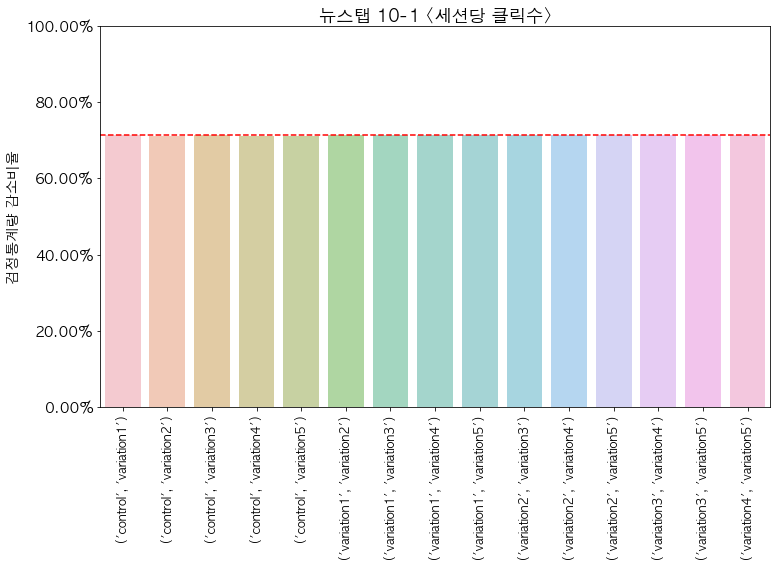

In [26]:
# 검정 통계량 감소율 확인

data_viz = pd.DataFrame({"x": list(combinations(grp_names, 2)), "y": (1 - np.divide(stat_delta, stat_naive))})

plt.figure(figsize=(12,7))
ax = sns.barplot(x="x", y="y", data=data_viz, alpha=0.5)
plt.axhline(data_viz.y.mean(), color="red", linestyle="--")


plt.title("뉴스탭 10-1 <세션당 클릭수>", fontsize="xx-large")
plt.xlabel("")
plt.ylabel("검정통계량 감소비율", fontsize="x-large")
plt.xticks(rotation="90", fontsize="large")
plt.yticks(fontsize="x-large")

plt.ylim([0,1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.show()

In [27]:
for name, val1, val2 in zip(combinations(grp_names, 2), pvalue_naive, pvalue_delta):
    print("{} /\t {} / \t{}".format(name, val1, val2))

('control', 'variation1') /	 6.828512332351446e-38 / 	0.00022557185671403108
('control', 'variation2') /	 0.0 / 	3.093784340008394e-138
('control', 'variation3') /	 0.0 / 	2.093472313364226e-50
('control', 'variation4') /	 0.0 / 	8.932674435285685e-86
('control', 'variation5') /	 0.0 / 	4.724609290522434e-167
('variation1', 'variation2') /	 0.0 / 	5.475385508104111e-174
('variation1', 'variation3') /	 0.0 / 	1.2395725634076331e-74
('variation1', 'variation4') /	 0.0 / 	2.120791159074144e-115
('variation1', 'variation5') /	 0.0 / 	6.389623417338537e-206
('variation2', 'variation3') /	 5.263815527542801e-280 / 	1.5511208253176387e-24
('variation2', 'variation4') /	 7.184788935995802e-75 / 	1.5380635503553738e-07
('variation2', 'variation5') /	 4.5102052144348837e-13 / 	0.03797918802596553
('variation3', 'variation4') /	 2.018862332371541e-65 / 	1.0226452266932767e-06
('variation3', 'variation5') /	 0.0 / 	8.10836955217406e-36
('variation4', 'variation5') /	 7.095208417217847e-147 / 	1.33

## CUPED

- user-level 지표에 대해서 분산 감소율 확인

In [182]:
def get_unique_user_id(data_pre, data_post, var_name):
    """
    서로 다른 두 기간 동안 (pre/post experiment) 동일하게 등장한 객체들의 user_id 반환
    """
    pre = data_pre[data_pre.variation == var_name].user_tuid_hash.unique()       # pre-experiment 유저 인덱스
    post = data_post[data_post.variation == var_name].user_tuid_hash.unique()    # post-experiment 유저 인덱스
    
    # pre/post 기간에 전부 등장한 유저들의 ID 집계
    common_pre = pd.Series(pre)[pd.Series(pre).isin(post)].unique() 
    common_post = pd.Series(post)[pd.Series(post).isin(pre)].unique() 
    common_unique_idx = pd.Series(np.concatenate([common_pre, common_post])).unique()

    return common_unique_idx

### 체류시간

In [247]:
metric_name = "체류시간(초)"
grp1_name = "control"
grp2_name = "variation3"

grp1_pre = df1_pre[df1_pre.variation == grp1_name].groupby("user_tuid_hash")[metric_name].mean()
grp1_post = df1_post[df1_post.variation == grp1_name].groupby("user_tuid_hash")[metric_name].mean()

grp2_pre = df1_pre[df1_pre.variation == grp2_name].groupby("user_tuid_hash")[metric_name].mean()
grp2_post = df1_post[df1_post.variation == grp2_name].groupby("user_tuid_hash")[metric_name].mean()

In [248]:
# 각 variant별 pre/post 실험 기간 모두 등장한 유저 ID
grp1_unique_idx = get_unique_user_id(df1_pre, df1_post, grp1_name)
grp2_unique_idx = get_unique_user_id(df1_pre, df1_post, grp2_name)

# 첫번째 variant에서 관심 지표에 대한 데이터
grp1_pre_unique = grp1_pre[grp1_pre.index.isin(grp1_unique_idx)]
grp1_post_unique = grp1_post[grp1_post.index.isin(grp1_unique_idx)]

# 두번째 variant에서 관심 지표에 대한 데이터
grp2_pre_unique = grp2_pre[grp2_pre.index.isin(grp2_unique_idx)]
grp2_post_unique = grp2_post[grp2_post.index.isin(grp2_unique_idx)]

# 아웃라이어 처리 적용
grp1_pre_capped = capping(grp1_pre_unique, zero_inflated=True)
grp1_post_capped = capping(grp1_post_unique, zero_inflated=True)
grp2_pre_capped = capping(grp2_pre_unique, zero_inflated=True)
grp2_post_capped = capping(grp2_post_unique, zero_inflated=True)

In [256]:
# CUPED 적용 X
n1 = len(grp1_post_capped)
n2 = len(grp2_post_capped)

var1 = grp1_post_capped.var()
var2 = grp2_post_capped.var()

diff = grp1_post_capped.mean() - grp2_post_capped.mean()
std_error = np.sqrt(var1/n1 + var2/n2)

zstat = diff / std_error
pvalue = norm.sf(abs(zstat))*2  # 양측 검정

print("검정통계량 (Z-score): {}".format(np.round(zstat, 4)))
print("p-value: {}".format(np.round(pvalue, 5))) 

검정통계량 (Z-score): 9.7478
p-value: 0.0


In [272]:
# CUPED 적용
n1 = len(grp1_post_capped)
n2 = len(grp2_post_capped)

X = pd.concat([grp1_pre_capped, grp2_pre_capped])
Y = pd.concat([grp1_post_capped, grp2_post_capped])
theta = np.cov(X, Y)[0,1] / np.var(X)
var1 = np.var(grp1_post_capped) * (1 - np.corrcoef(X, Y)[0,1])
var2 = np.var(grp2_post_capped) * (1 - np.corrcoef(X, Y)[0,1])

cuped_diff = (grp1_post_capped.mean() - theta*grp1_pre_capped.mean()) - (grp2_post_capped.mean() - theta*grp2_pre_capped.mean())
cuped_std_error = np.sqrt(var1/n1 + var2/n2)

zstat = cuped_diff / cuped_std_error
pvalue = norm.sf(abs(zstat))*2  # 양측 검정

print("표준오차 감소율: {:.3f}%".format((1 - cuped_std_error/std_error) * 100))
print("검정통계량 (Z-score): {}".format(np.round(zstat, 4)))
print("p-value: {}".format(np.round(pvalue, 5))) 

표준오차 감소율: 45.664%
검정통계량 (Z-score): 2.0702
p-value: 0.03843


In [251]:
print(grp1_post_capped.mean())
print(grp2_post_capped.mean())

74.92423857364166
70.78524605874112


In [266]:
X = pd.concat([grp1_pre_capped, grp2_pre_capped])
Y = pd.concat([grp1_post_capped, grp2_post_capped])
theta = np.cov(X, Y)[0,1] / np.var(X)

grp1_post_capped.mean() - theta*grp1_pre_capped.mean()

22.861322633912344

In [267]:
grp2_post_capped.mean() - theta*grp2_pre_capped.mean()

22.38369331343442

In [268]:
grp1_post_capped.mean() - grp2_post_capped.mean()

4.138992514900536

In [270]:
grp1_post_capped.mean()

74.92423857364166

In [271]:
grp2_post_capped.mean()

70.78524605874112

In [254]:
diff

4.138992514900536

In [253]:
cuped_diff

0.8677221849263432

In [252]:
(1-np.corrcoef(grp1_pre_capped, grp1_post_capped)[0,1])

0.2938405456798423